# Metodo dei Momenti applicato ai dati di Centa San Nicolò

Matteo Franzoi - 2019-03-22

---

Per prima cosa si importano le librerie necessarie

In [2]:
import os
from pandas import *
import pandas as pd
from numpy import *
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import math
from datetime import datetime
from scipy.stats import genextreme, gumbel_r
from numpy import linspace
from statsmodels.distributions.empirical_distribution import ECDF

La cartella di lavoro è

In [3]:
os.getcwd()

'/media/data/jupyter/esercitazione'

e contiene il file *csv* che serve

In [4]:
os.listdir()

['.ipynb_checkpoints',
 'abs_m',
 'abs_mle',
 'massimePrecipitazioniCenta.csv',
 'mleCenta.ipynb',
 'momentiCenta.ipynb']

Attraverso i pandas è possibile leggere il file *csv* e immagazzinarlo nella variabile data.  
In seguito, viene settato come indice l'anno

In [5]:
pd.set_option('display.max_rows', 20)
data = read_csv('massimePrecipitazioniCenta.csv')
map(datetime, data['anno'])
data = data.set_index('anno')
data

,1h,3h,6h,12h,24h
anno,,,,,
1934,22.6,42.0,56.6,58.8,85.0
1935,17.8,32.6,54.2,63.6,88.0
1936,15.8,28.0,41.4,72.0,85.2
1937,27.8,35.6,38.2,58.4,62.6
1938,15.0,21.4,32.0,56.0,83.0
1939,29.4,36.2,61.0,115.2,117.8
1940,28.8,67.0,94.0,119.0,135.2
1941,14.2,21.0,25.6,44.0,51.0
1942,27.0,42.0,66.2,82.6,85.6


Per il metodo dei momenti è necessario calcolare la media e la deviazione standard del DataFrame **data**, per ogni valore di durata

In [6]:
means = np.mean(data)
means

1h     24.115789
3h     35.736842
6h     48.394737
12h    69.085714
24h    91.577193
dtype: float64

In [7]:
variances = data.var()
variances

1h       89.932782
3h      173.233083
6h      272.360865
12h     730.971429
24h    1215.426792
dtype: float64

In [8]:
stds = data.std()
stds

1h      9.483290
3h     13.161804
6h     16.503359
12h    27.036483
24h    34.862972
dtype: float64

Dal metodo dei momenti risulta un sistema di due equazioni in due incognite *a* e _b_, dove

In [9]:
b = math.sqrt(6) / math.pi
b

0.779696801233676

In [10]:
EulerGamma = 0.577215664901532860606512090
#-------------------------------------------
b * EulerGamma 

0.4500532075456946

Si definisce la funzione **g** che ha come input la media e la deviazione standard e come output il DataFrame che contiene i valori di _a_ e *b* per ogni durata

In [11]:
def g(m, s):
    return pd.DataFrame([m - b * EulerGamma * s, b * s], index = ['a', 'b'])

Ricordando che _a_ è un parametro di posizione e *b* è un parametro di scala, il DataFrame che contiene i parametri calcolati con il metodo dei momenti è

In [12]:
abs_m = g(means, stds)
abs_m

,1h,3h,6h,12h,24h
a,19.847805,29.813330,40.967347,56.917858,75.887001
b,7.394091,10.262216,12.867616,21.080260,27.182547


È possibile salvare il DataFrame in un file per usarlo in seguito

In [13]:
abs_m.to_pickle('abs_m')

In [14]:
os.listdir()

['.ipynb_checkpoints',
 'abs_m',
 'abs_mle',
 'massimePrecipitazioniCenta.csv',
 'mleCenta.ipynb',
 'momentiCenta.ipynb']

['.ipynb_checkpoints',  
 '**abs_m**',  
 'massimePrecipitazioniCenta.csv',  
 'momentiCenta.ipynb']

Si definisce la curva di Gumbel dalla sua definizione
$$
\Large{e^{-e^{-\frac{h-a}{b}}}}
$$
La funzione ha come input il vettore **x** delle altezze di precipitazione, il generico DataFrame __abs_d__ e la colonna riferita ai valori di durata

In [15]:
def gumbel(x, abs_d, col):
    return np.exp(-np.exp(-(x - abs_d[col]['a']) / abs_d[col]['b']))

Ora, si crea un vettore **t_rain** di 100 elementi che contiene tutti i valori compresi tra il minimo e il massimo di precipitazione fra tutte le durate.  
Il valore minimo sarà quello riferito a 1h

In [16]:
data.min()

1h     12.6
3h     20.0
6h     24.0
12h    24.2
24h    43.6
dtype: float64

In [17]:
data.min()['1h']

12.6

mentre il massimo sarà quello riferito alle 24h

In [18]:
data.max()

1h      55.8
3h      79.0
6h     103.8
12h    152.2
24h    192.0
dtype: float64

In [19]:
data.max()['24h']

192.0

Il vettore sarà

In [20]:
t_rain = np.linspace(data.min()['1h'], data.max()['24h'], 100)

Si può definire ora un DataFrame che ha i valori di **t_rain** come indice e che contiene i valori derivanti dalla funzione di gumbel con input il vettore **t_rain**, il DataFrame __abs_m__ e la durata considerata

In [21]:
gb = pd.DataFrame([
    gumbel(t_rain, abs_m, '1h'),
    gumbel(t_rain, abs_m, '3h'),
    gumbel(t_rain, abs_m, '6h'),
    gumbel(t_rain, abs_m, '12h'),
    gumbel(t_rain, abs_m, '24h')
]).T #Trasposta
#L'indice che si imponte è t_rain
gb.index = t_rain
#Le colonne sono i valori di durata delle precipitazioni
gb.columns = ['1h', '3h', '6h', '12h', '24h']
#------------------------------------------
gb

,1h,3h,6h,12h,24h
12.600000,0.069597,0.004742,0.000116,0.000279,0.000035
14.412121,0.124211,0.011275,0.000380,0.000547,0.000068
16.224242,0.195457,0.023304,0.001069,0.001016,0.000126
18.036364,0.278705,0.042825,0.002626,0.001792,0.000225
19.848485,0.367913,0.071315,0.005733,0.003017,0.000387
21.660606,0.457228,0.109350,0.011293,0.004865,0.000642
23.472727,0.542007,0.156460,0.020352,0.007545,0.001031
25.284848,0.619185,0.211255,0.033946,0.011284,0.001606
27.096970,0.687179,0.271706,0.052940,0.016326,0.002432
28.909091,0.745561,0.335507,0.077881,0.022914,0.003586


## Plot delle curve di Gumbel

Per il plot delle curve, si setta una grandezza delle etichette pari a 20 e si sceglie un colore per ogni curva di Gumbel.  
Si sovrappongono poi i dati calcolati con la ECDF per ogni durata

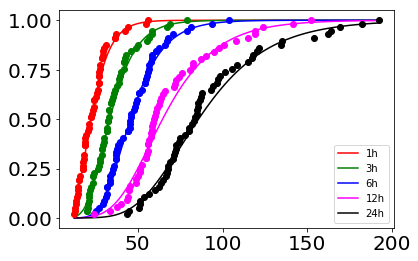

In [22]:
plt.rc('xtick', labelsize = 20)
plt.rc('ytick', labelsize = 20)

#----------------plot---------------

ax = gb.plot(color = ['red', 'green', 'blue', 'magenta', 'black'])

#--------------1h--------------------
data1h = data['1h'].dropna()
ecdf1h = ECDF(data1h)
ax.plot(data1h, ecdf1h(data1h), 'o', c = 'red')

#--------------3h--------------------
data3h = data['3h'].dropna()
ecdf3h = ECDF(data3h)
ax.plot(data3h, ecdf3h(data3h), 'o', c = 'green')

#--------------6h--------------------
data6h = data['6h'].dropna()
ecdf6h = ECDF(data6h)
ax.plot(data6h, ecdf6h(data6h), 'o', c = 'blue')

#--------------12h-------------------
data12h = data['12h'].dropna()
ecdf12h = ECDF(data12h)
ax.plot(data12h, ecdf12h(data12h), 'o', c = 'magenta')

#--------------24h-------------------
data24h = data['24h'].dropna()
ecdf24h = ECDF(data24h)
ax.plot(data24h, ecdf24h(data24h), 'o', c = 'black')

#------------------------------------
plt.show()

**dropna()** separa ed elimina i dati NaN